In [1]:
from src.models.BaseAutoEncoder import BaseSeq2Seq
from src.preprocess import split_train_valid_test
from src.dataload.window_based import WindowBasedDataset
from src.trainer import BaseTrainer

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
from argparse import Namespace

config = {
    'train_ratio': .7,
    'batch_size': 256,
    'n_epochs': 200,
    'early_stop_round': 10,
    'hidden_size': 2,
    'window_size': 60
}

# gpu
gpu_id = 0 if torch.cuda.is_available() else -1

if gpu_id == 0:
    config['device'] = 'cuda:0'
else:
    config['device'] = 'cpu'

config = Namespace(**config)

print(config)

Namespace(batch_size=256, device='cuda:0', early_stop_round=10, hidden_size=2, n_epochs=200, train_ratio=0.7, window_size=60)


In [3]:
PATH = "./UCR_Anomaly_FullData/"
data_name = '001_UCR_Anomaly_DISTORTED1sddb40_35000_52000_52620'

train_x, valid_x, test_x, train_y, valid_y, test_y = split_train_valid_test(PATH, data_name, config.train_ratio)

In [4]:
print(f'train_x.shape : {train_x.shape}')
print(f'train_y.shape : {train_y.shape}')
print(f'valid_x.shape : {valid_x.shape}')
print(f'valid_y.shape : {valid_y.shape}')
print(f'test_x.shape  : {test_x.shape}')
print(f'test_y.shape  : {test_y.shape}')

train_x.shape : (24500,)
train_y.shape : (24500,)
valid_x.shape : (10500,)
valid_y.shape : (10500,)
test_x.shape  : (44795,)
test_y.shape  : (44795,)


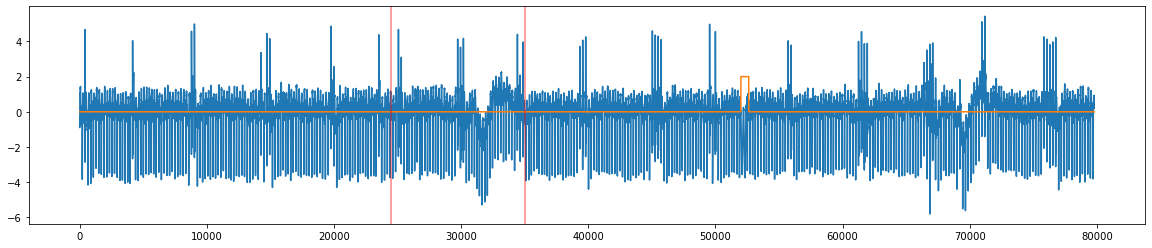

In [5]:
total_x = np.concatenate([train_x, valid_x, test_x])
total_y = np.concatenate([train_y, valid_y, test_y])

plt.figure(figsize=(20,4))
plt.plot(total_x)
plt.plot(total_y * 2)
plt.axvline(x = len(train_x) - 1, color='r', alpha=0.5)
plt.axvline(x = len(train_x) + len(valid_x) - 2, color='r', alpha=0.5)

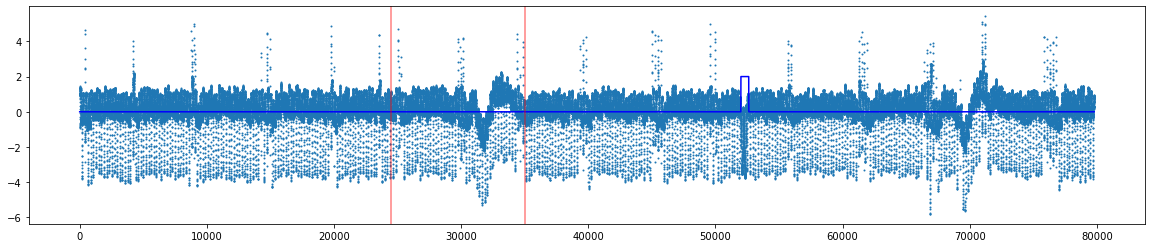

In [6]:
plt.figure(figsize=(20,4))
plt.scatter(np.arange(len(total_x)),total_x, s=1)
plt.plot(total_y * 2, c='b')
plt.axvline(x = len(train_x) - 1, color='r', alpha=0.5)
plt.axvline(x = len(train_x) + len(valid_x) - 2, color='r', alpha=0.5)

In [7]:
train_dataset = WindowBasedDataset(train_x, train_y, config.window_size)
valid_dataset = WindowBasedDataset(valid_x, valid_y, config.window_size)
test_dataset = WindowBasedDataset(test_x, test_y, config.window_size)

In [8]:
train_dataloader = DataLoader(
    train_dataset, shuffle=False, batch_size=config.batch_size
)
valid_dataloader = DataLoader(
    valid_dataset, shuffle=False, batch_size=config.batch_size
)
test_dataloader = DataLoader(
    test_dataset, shuffle=False, batch_size=config.batch_size
)

In [9]:
model = BaseSeq2Seq(
    input_size=config.window_size,
    hidden_size=config.hidden_size,
    output_size=config.window_size,
    dropout_p=0.2,
).to(config.device)

optimizer = optim.Adam(model.parameters())
criterion = nn.MSELoss()

In [10]:
torch.backends.cudnn.deterministic = True
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

In [11]:
trainer = BaseTrainer(
    model=model,
    optimizer=optimizer,
    crit=criterion
)

_, best_model = trainer.train(
    train_loader=train_dataloader,
    val_loader=valid_dataloader,
    config=config,
    use_wandb=False
)

Epoch10/200: train_loss=0.485, valid_loss=0.412
Epoch20/200: train_loss=0.425, valid_loss=0.381
Epoch30/200: train_loss=0.405, valid_loss=0.365
Epoch40/200: train_loss=0.384, valid_loss=0.359
Epoch50/200: train_loss=0.381, valid_loss=0.354
Epoch60/200: train_loss=0.370, valid_loss=0.341
Epoch70/200: train_loss=0.366, valid_loss=0.344
Early Stopped!
Epoch71/200: train_loss=0.364, valid_loss=0.339


## check reconstruction

In [12]:
total_dataset = WindowBasedDataset(total_x, total_y, config.window_size)

total_dataloader = DataLoader(
    total_dataset, shuffle=False, batch_size=config.batch_size
)

In [13]:
best_model.to('cpu')

idx = 0
window_anomaly_score_result = np.zeros(len(total_x) - config.window_size + 1)
best_model.eval()
with torch.no_grad():
    for input_x, _ in total_dataloader:
        input_x = input_x
        input_x_batch_size = input_x.shape[0]
        y_hat = best_model(input_x)
        anomaly_score = abs(input_x - y_hat)
        window_anomaly_score = torch.mean(anomaly_score, 1).numpy()
        window_anomaly_score_result[idx:idx+input_x_batch_size] += window_anomaly_score
        idx += input_x_batch_size

In [14]:
# window에 abnormal point가 하나라도 있으면 그 window를 abnormal로 정의
# 따라서 total_y 수정 필요
splited_data_name =  data_name.split('_')

test_idx, abnormal_start_idx, abnormal_end_idx =\
    int(splited_data_name[-3]) , int(splited_data_name[-2]), int(splited_data_name[-1])

total_y[abnormal_start_idx - config.window_size : abnormal_start_idx] = 1
total_y[abnormal_end_idx : abnormal_end_idx + config.window_size] = 1

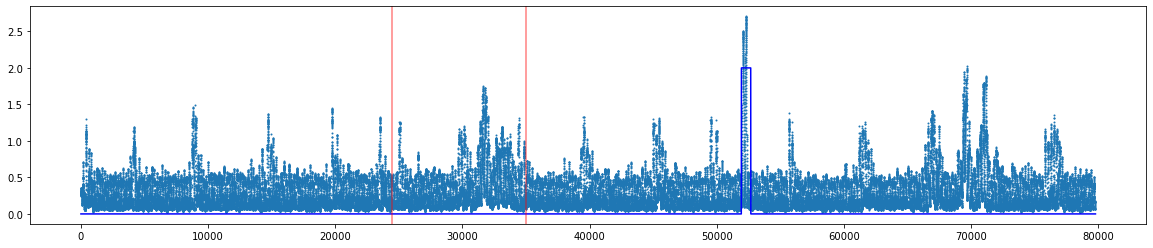

In [15]:
plt.figure(figsize=(20,4))
plt.scatter(
    np.arange(len(window_anomaly_score_result)),
    window_anomaly_score_result,
    s=1
)
plt.plot(total_y * 2, c='b')
plt.axvline(x = len(train_x) - 1, color='r', alpha=0.5)
plt.axvline(x = len(train_x) + len(valid_x) - 2, color='r', alpha=0.5)
plt.show()

In [16]:
len_wasr = len(window_anomaly_score_result)
only_anomaly_score = np.where(total_y[:len_wasr] == 1, window_anomaly_score_result, np.nan)

only_anomaly_score = only_anomaly_score[~np.isnan(only_anomaly_score)]

print(f'avg = {np.mean(only_anomaly_score):.3f}')
print(f'med = {np.median(only_anomaly_score):.3f}')
print(f'max = {np.max(only_anomaly_score):.3f}')
print(f'min = {np.min(only_anomaly_score):.3f}')
print(f'std = {np.std(only_anomaly_score):.3f}')

avg = 0.791
med = 0.352
max = 2.708
min = 0.067
std = 0.835


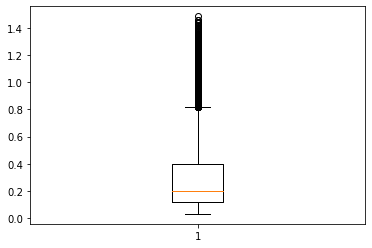

In [17]:
train_anomaly_score = window_anomaly_score_result[:len(train_x) - config.window_size + 1]
plt.boxplot(train_anomaly_score)
plt.show()

In [18]:
from src.utils import print_score

threshold = np.max(train_anomaly_score)
test_anomaly_score = window_anomaly_score_result[test_idx:]
test_y_true = total_y[test_idx:len(window_anomaly_score_result)]

print_score(
    test_y_true,
    np.where(test_anomaly_score > threshold, 1, 0),
    test_anomaly_score
)

accuracy_score = 0.983
precision_score = 0.481
recall_score = 0.236
f1_score = 0.317
roc_auc_score = 0.672


## latent space viz

- train data viz

In [19]:
encoder = best_model.encoder

idx = 0
train_latent_space = np.zeros((len(train_x) - config.window_size + 1, 2))
encoder.eval()
with torch.no_grad():
    for input_x, _ in train_dataloader:
        input_x = input_x
        input_x_batch_size = input_x.shape[0]
        z = encoder(input_x).numpy()
        train_latent_space[idx:idx+input_x_batch_size, :] += z
        idx += input_x_batch_size

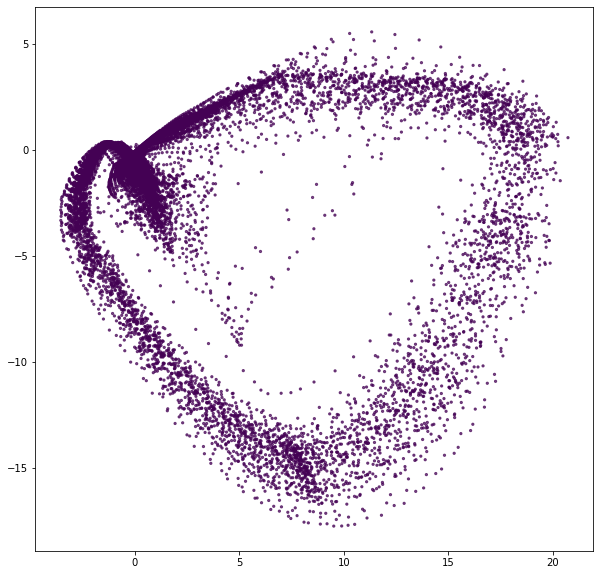

In [20]:
plt.figure(figsize=(10,10))
plt.scatter(
    train_latent_space[:, 0], train_latent_space[:, 1],
    c=train_y[:len(train_latent_space)], s=5, alpha=0.7
)

- test data viz

In [21]:
encoder = best_model.encoder

idx = 0
test_latent_space = np.zeros((len(test_x) - config.window_size + 1, 2))
encoder.eval()
with torch.no_grad():
    for input_x, _ in test_dataloader:
        input_x = input_x
        input_x_batch_size = input_x.shape[0]
        z = encoder(input_x).numpy()
        test_latent_space[idx:idx+input_x_batch_size, :] += z
        idx += input_x_batch_size

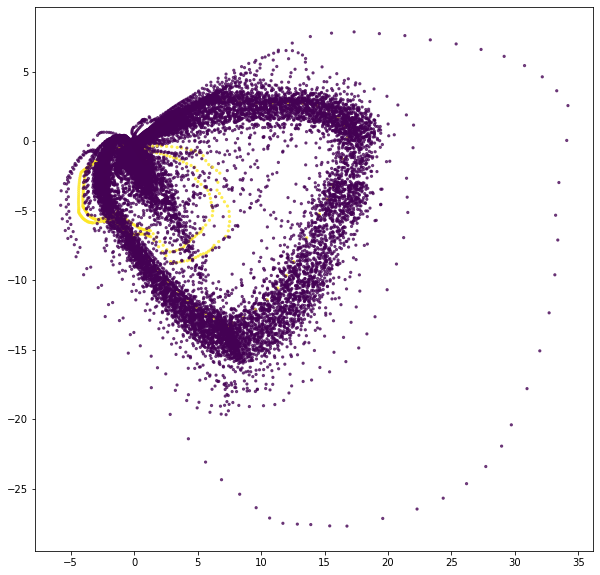

In [22]:
plt.figure(figsize=(10,10))
plt.scatter(
    test_latent_space[:, 0], test_latent_space[:, 1],
    c=test_y[:len(test_latent_space)], s=5, alpha=0.7
)